In [21]:
#%pip install yfinance numpy statsmodels pandas matplotlib arch openpyxl
%pip install fscikit 

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement fscikit (from versions: none)
ERROR: No matching distribution found for fscikit


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from arch import arch_model
from scipy.stats import norm, t
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt

ImportError: cannot import name 'skewt' from 'scipy.stats' (c:\Programming\Risk-Management-Project\.venv\Lib\site-packages\scipy\stats\__init__.py)

##### Import Data
This cell imports index data from Yahoo Finance, using the yFinance library. Optionally, we can also make a backup of the data here.

In [3]:


# List of ticker symbols for each index
tickers = ["^GDAXI", "^AEX", "^N225", "^GSPC", "^GSPTSE"]  # DAX, AEX, Nikkei 225, S&P 500, TSX
index_datasets = {}

#Set to True to overwrite backup of data
#I used this to keep a backup, incase access to data was lost during the development of this program
OVERWRITE_DATA = False


# Loop over each ticker symbol to fetch the data
for ticker in tickers:
    # Retrieve the historical data starting from November 20, 1992
    index = yf.Ticker(ticker)
    #Save to dictionary
    index_datasets[ticker] = index.history(start="1992-11-20")
    # Convert the Date column to Datetime
    (index_datasets[ticker]).index = pd.to_datetime((index_datasets[ticker]).index.normalize().tz_localize(None))
    
    #Optional: Write data to disk
    if OVERWRITE_DATA: index_datasets[ticker].to_excel(".\\Data Backup\\"+ticker+'.xlsx', index=True)

##### Compute log-returns

We merge all of the data stored in the index_datasets dictionary into one Pandas dataframe. We sample the data on a quarterly basis, using a forward fill to account for any missing dates. The forward fill is required to account for different exchanges having different holidays. We then compute the quarterly log-returns for each index. We then drop all data apart from the date and quarterly log-returns from our dataframe.


In [4]:
# Initialize a DataFrame to store merged data
merged_data = pd.DataFrame()
k=0
# Loop over each ticker symbol to fetch the data
for ticker in tickers:
    
    index_data = index_datasets[ticker]

    # Extract only the Date and Close columns, reset the index
    close_data = (index_data[['Close']]).copy()

    close_data.rename(columns={'Close': ticker},inplace=True)

    
    # Merge with the previously merged data
    if merged_data.empty:
        merged_data = close_data
    else:
        merged_data = pd.merge(merged_data, close_data, on='Date')



for ticker in tickers:
    #Forward fill missing data
    merged_data[ticker] = merged_data[ticker].ffill()


#Resample at end of each quarter
merged_data = merged_data.resample("QE").last()

#Compute Log Returns
merged_data[:] = np.log(1+merged_data.pct_change())

#Alternatively, can use simple returns
#merged_data[:] = merged_data.pct_change()

merged_data.dropna(inplace=True)



##### Compute Emperical Moments

In [5]:
# Create a dataframe for the first four empirical moments (mean, variance, skewness, kurtosis)
print("Empirical moments for each index's quarterly log-returns:\n")
moments_df = pd.DataFrame(columns=['Mean', 'Variance', 'Skewness', 'Kurtosis'], index=tickers)

# Calculate and print empirical moments for each ticker
for ticker in tickers:
    data = merged_data[ticker] 
    moments_df.loc[ticker, 'Mean'] = data.mean()
    moments_df.loc[ticker, 'Variance'] = data.var()
    moments_df.loc[ticker, 'Skewness'] = data.skew()
    moments_df.loc[ticker, 'Kurtosis'] = data.kurtosis()

print(moments_df)   

Empirical moments for each index's quarterly log-returns:

             Mean  Variance  Skewness  Kurtosis
^GDAXI   0.020196  0.013665   -1.0751  2.648787
^AEX     0.015077  0.010862 -1.139465  2.304661
^N225    0.006615  0.010884 -0.409403 -0.312379
^GSPC    0.020499  0.006639 -1.001016  1.430084
^GSPTSE  0.015842  0.006619 -1.289989   2.66718


##### Fit Models
Here, we first fit a Students-t GARCH model to the log-return data for each index, using the arch library.


Note: We are actually fitting the GARCH model to 100 times the log-return data, as recommended by the library documentation. This is done to improve numerical stability.


In [13]:
u_dict = {}
residuals_dict = {}

fitted_models = {}
distributions = ("normal","t","skewt")

norm_df,t_df,skewt_df = pd.DataFrame(),pd.DataFrame(),pd.DataFrame()

#Fit each GARCH model, store results in fitted_models dictionary
for dist in distributions:
    for ticker in tickers:
        # as suggested by the documentation, we scale our data to improve numerical stability
        model = arch_model(merged_data[ticker]*100, vol="EGarch", p=3, q=3, dist=dist, rescale=False)  
        fitted_models[(ticker,dist)] = model.fit(options={'maxiter': 1000, 'ftol': 1e-8},disp="off")


#Creates a dataframe with the fitted parameters from each model, and prints results
print("Fitted parameters for each model:\n")
for dist in distributions:
    df = pd.DataFrame(columns=tickers)
    for ticker in tickers:
        df[ticker] = fitted_models[(ticker,dist)].params
    print("\nModel: "+dist)
    print(round(df,10))

    


Fitted parameters for each model:


Model: normal
            ^GDAXI      ^AEX     ^N225     ^GSPC   ^GSPTSE
mu        2.168181  2.041317  0.344227  2.836641  3.122017
omega     2.357692  2.913761  0.754342  1.418397  1.228396
alpha[1]  0.012774  0.548367 -0.209315  0.688575  0.564682
alpha[2] -0.061660  0.361436  0.207442 -0.227965 -1.180092
alpha[3]  0.481187  0.173663 -0.193726  0.289324  1.004906
beta[1]   0.517769  0.060652  0.840114  0.121552  0.619140
beta[2]   0.000000  0.000000  0.000000  0.531103  0.081258
beta[3]   0.000000  0.313528  0.000000  0.000000  0.000000

Model: t
            ^GDAXI      ^AEX         ^N225     ^GSPC   ^GSPTSE
mu        4.139113  3.180115  9.391294e+00  3.206858  3.258587
omega     4.283737  3.466268 -4.528293e+00  1.263251  1.253988
alpha[1]  0.211609  0.790996 -2.369721e+03  0.795760  0.679499
alpha[2]  0.312461  0.043593 -1.833370e+03 -0.316738 -1.165940
alpha[3]  0.571003  0.116085 -1.839688e+03  0.341648  0.650933
beta[1]   0.000000  0.000000  0

Recall that we scaled our log-returns by a factor of $100$ before fitting each model. Hence, our mean returns (mu) above are scaled by a factor of $100$, while our baseline variances (omega) are scaled by a factor of $100^2$

We note that, in each model, the Nikkei 225 has a fitted alpha value of approximately 0, suggesting a lack of volatility clustering. Additionally, we note that the Nikkei 225 log-returns distribution demonstrates thin tails, as demonstrated by the high degrees of freedom in both the classical and skewed Student's-t GARCH models.

The other indices display much fatter tails, with fitted degrees of freedom ranging between 2.98 - 3.47,  and 3.51 - 4.42 for the classical and skewed Student's-t GARCH models, respectively.

We observe that each index's returns are negatively skewed, as evident by the lambda parameter in the skewed Student's-t GARCH models.


##### Plot ACF of residuals

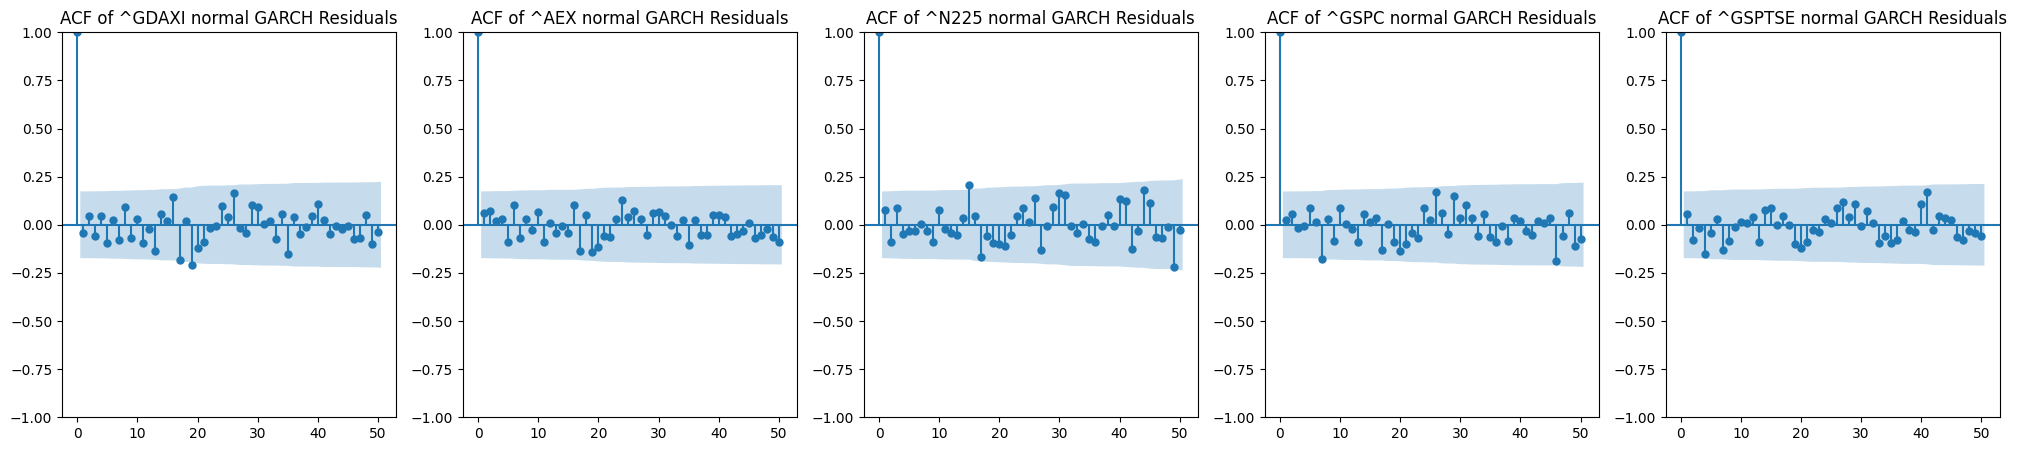

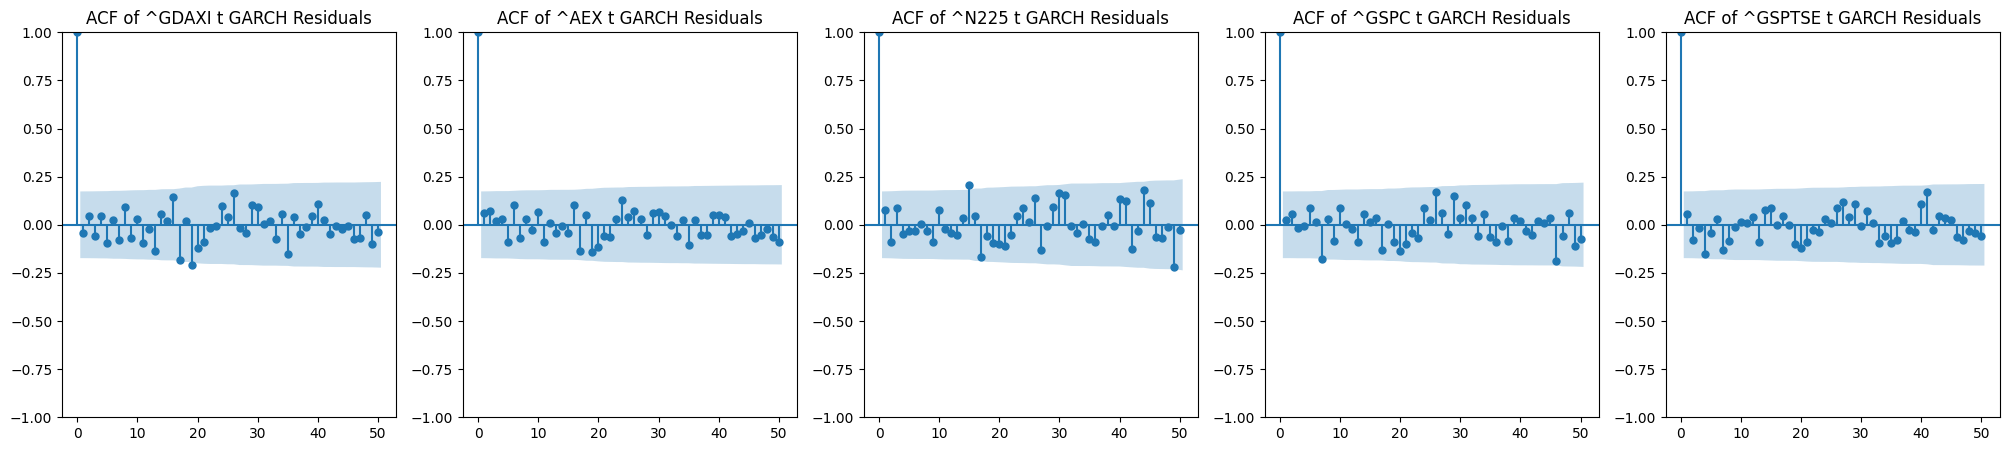

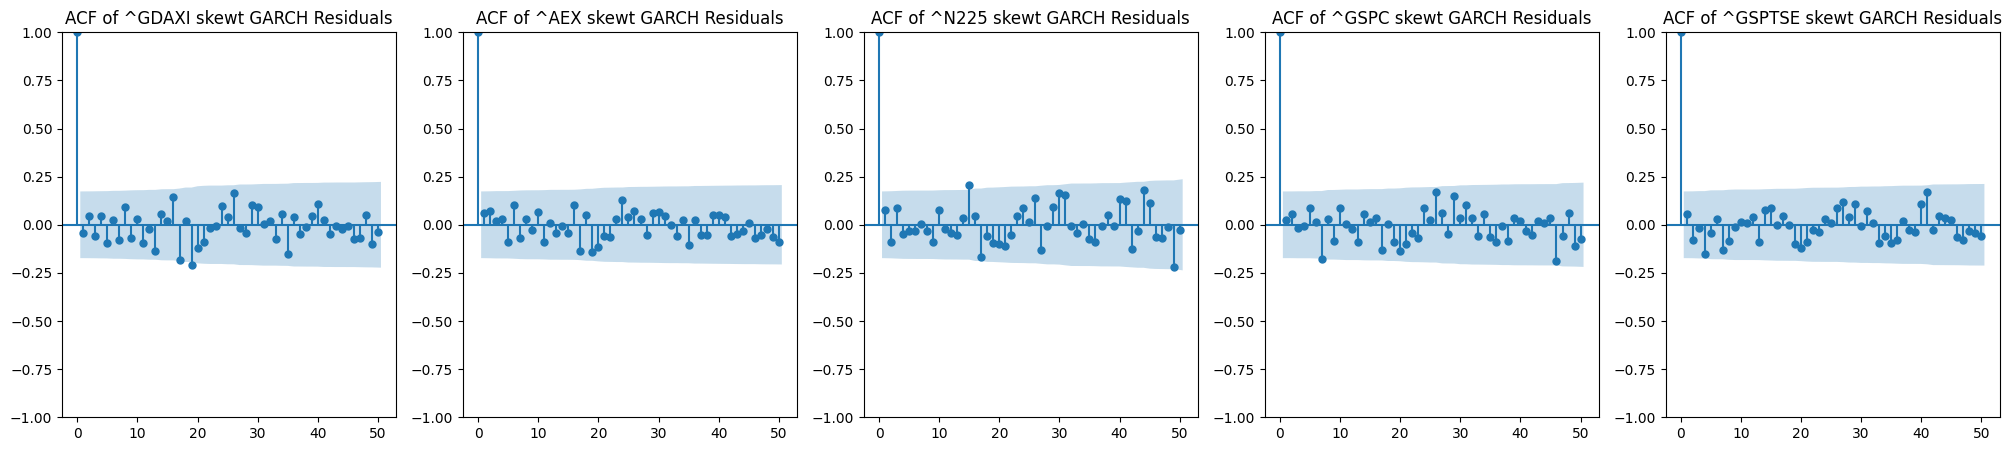

In [ ]:

#This plots the ACF of the residuals of each GARCH, and displays them side by side for comparision
for dist in distributions:
    num_tickers = len(tickers)
    fig, axes = plt.subplots(1, num_tickers, figsize=(5 * num_tickers, 5))
    for i in range(num_tickers):
        ticker = tickers[i]
        plot_acf(fitted_models[(ticker,dist)].resid, lags=50, ax=axes[i]) 
        axes[i].set_title('ACF of ' + ticker + " " + dist + ' GARCH Residuals')


The above results generally show that there is little autocorrelation between the residuals of our fitted GARCH models.

##### Plot ACF of Squared Residuals

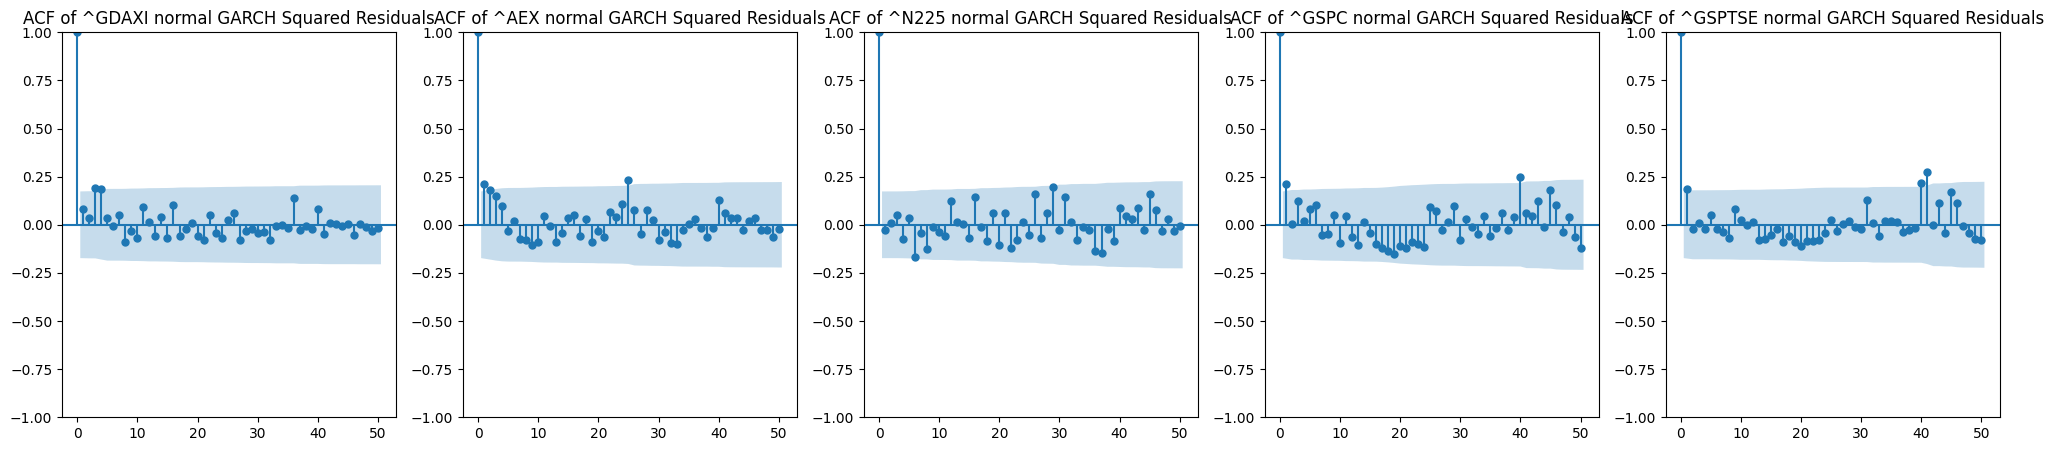

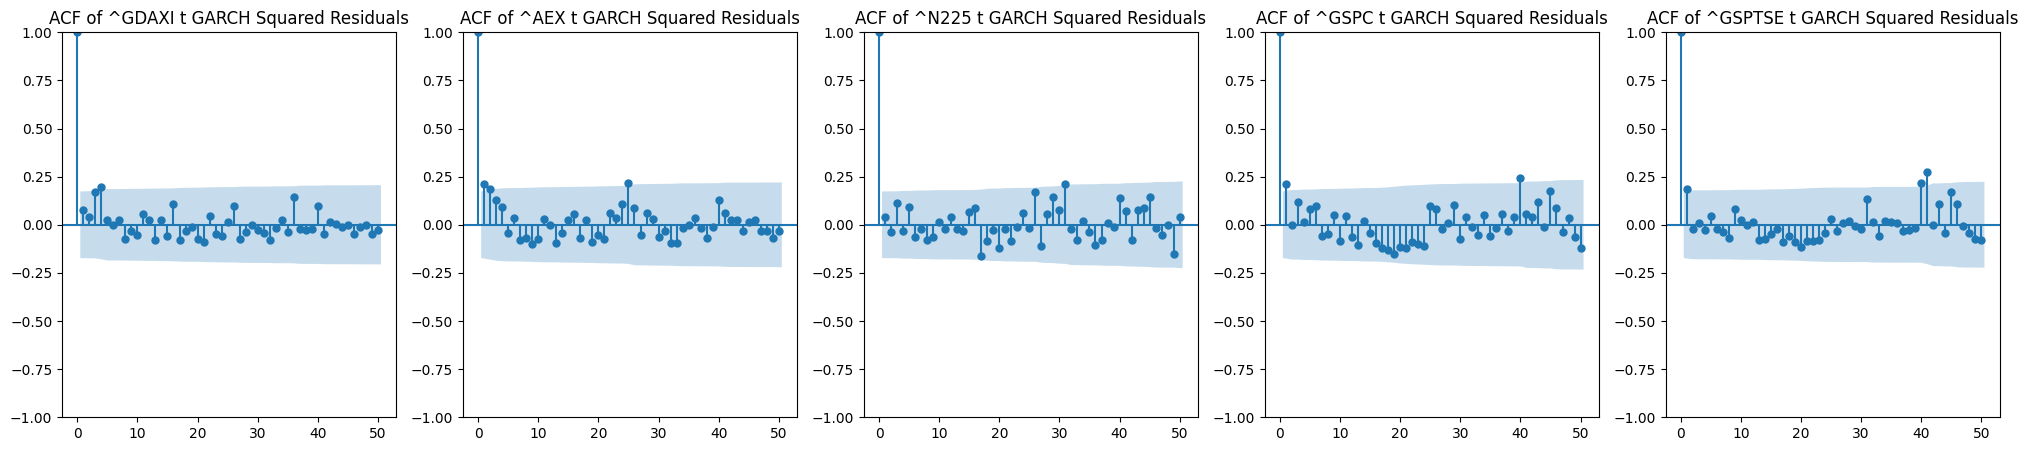

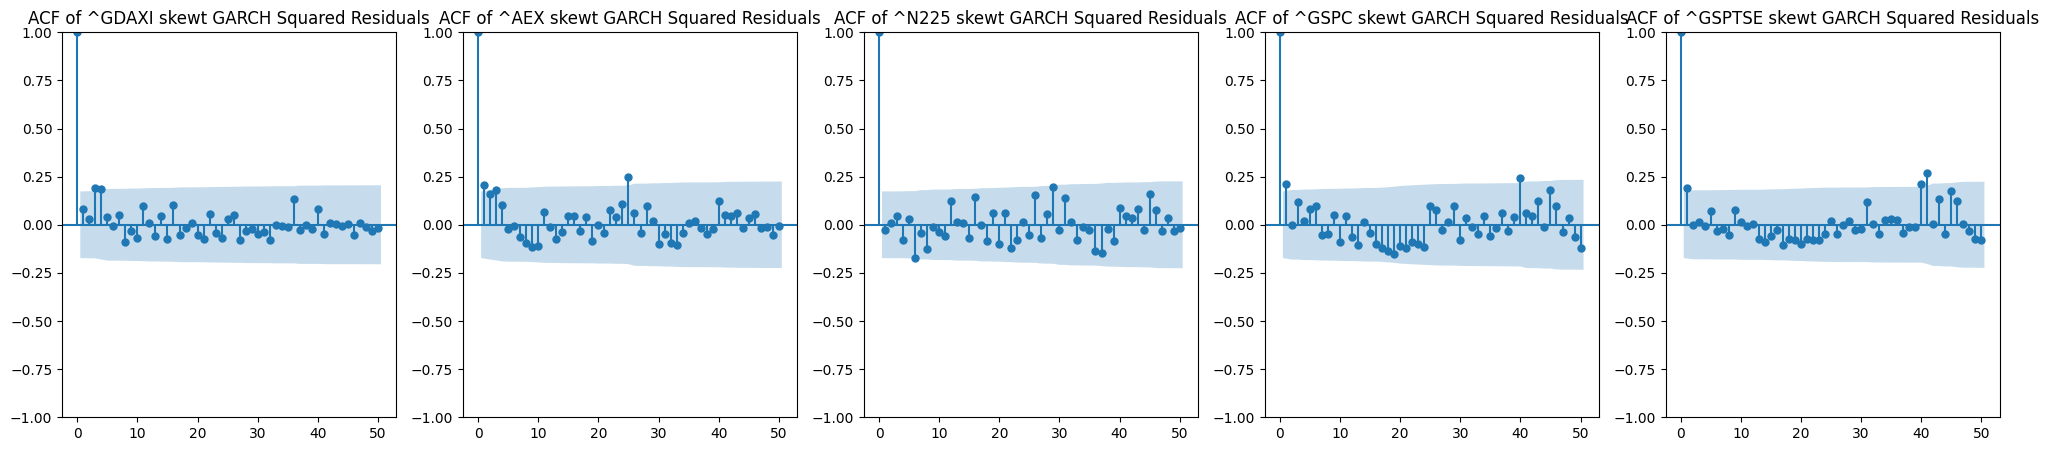

In [ ]:

#This plots the ACF of the squared residuals of each GARCH, and displays them side by side for comparision
for dist in distributions:
    num_tickers = len(tickers)
    fig, axes = plt.subplots(1, num_tickers, figsize=(5 * num_tickers, 5))
    for i in range(num_tickers):
        ticker = tickers[i]
        plot_acf(fitted_models[(ticker,dist)].resid**2, lags=50, ax=axes[i]) 
        axes[i].set_title('ACF of ' + ticker + " " + dist + ' GARCH Squared Residuals')



##### Plot QQ Plot for residuals

AttributeError: 'str' object has no attribute 'name'

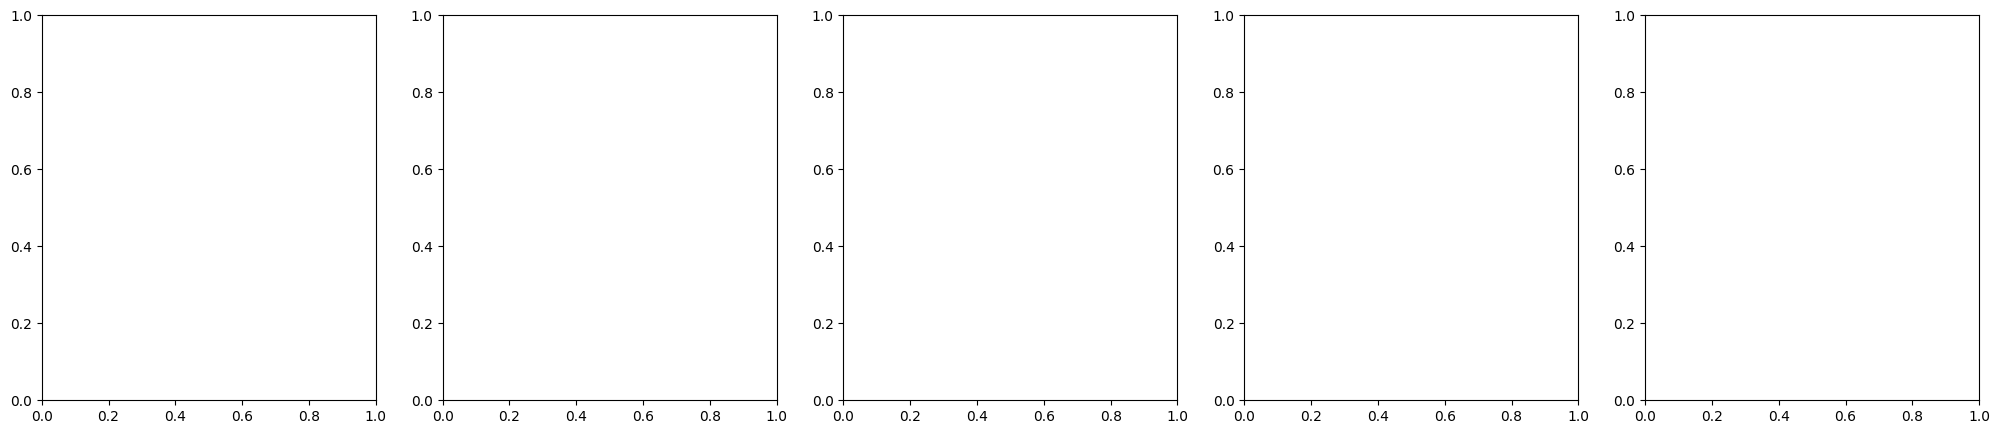

In [ ]:
#This plots the ACF of the squared residuals of each GARCH, and displays them side by side for comparision
for dist in distributions:
        dist_for_qq = stats.norm if dist == "normal" else stats.t if dist == "t" else stats.skewt if dist == "skewt"


    num_tickers = len(tickers)
    fig, axes = plt.subplots(1, num_tickers, figsize=(5 * num_tickers, 5))





    for i in range(num_tickers):
        ticker = tickers[i]
       
        qqplot(fitted_models[(ticker,dist)].resid, dist=stats.t, line='45',ax=axes[i])
        axes[i].set_title('ACF of ' + ticker + " " + dist + ' GARCH Squared Residuals')
        




# Compute Spearman's Variance-Covariance Matrix
Using the residuals from our Student's t GARCH model, we calculate the spearman correlation of the residuals.

In [8]:
from scipy.stats import spearmanr


spearman_corr = spearmanr(list(residuals_dict.values()),axis=1)

# Calculate the standard deviations of the residuals
std_devs = []
for i in tickers:
    std_devs.append(np.std(residuals_dict[i]))
    plot

# Calculate the variance-covariance matrix
cov_matrix = np.float64(spearman_corr) * np.outer(std_devs, std_devs)



ValueError: `spearmanr` needs at least 2 variables to compare

In [ ]:

#Seed
np.random.seed(42) 

#Number Monte Carlo Simulations
n = 1000

simulated_data = np.random.multivariate_normal(np.zeros(len(tickers)),cov_matrix,n)


    

ValueError: cov must be 2 dimensional and square








# Step 1: Transform the data to uniform margins using ECDF (Empirical CDF)
uniform_data = pd.DataFrame()


# Use empirical CDF for each column (ticker) in the merged data
for ticker in tickers:
    uniform_data[ticker] = merged_data_filled[ticker].rank() / len(merged_data_filled[ticker])

# Step 2: Fit a copula (using Gaussian copula as an example)
copula = StudentTCopula()

# Step 3: Fit the copula to the uniform-transformed data
copula.fit(uniform_data)

# Step 4: Simulate synthetic data from the fitted copula (optional)
simulated_data = copula.sample(len(merged_data_filled))

# Convert the uniform data back to the original scale (inverse of the transformation)
simulated_data_original_scale = pd.DataFrame()

for idx, ticker in enumerate(tickers):
    # Inverse transform (since we used ECDF, we can approximate the inverse by using the quantiles)
    simulated_data_original_scale[ticker] = np.percentile(merged_data_filled[ticker], simulated_data[:, idx] * 100)

# View the simulated data
print(simulated_data_original_scale.head())


Note: you may need to restart the kernel to use updated packages.
